
# Proyecto End‑to‑End (datos **reales**): Cambio Climático (1980–2024)

Este notebook descarga y analiza **datos públicos** de fuentes oficiales para explicar y modelar la anomalía de temperatura:
- **Temperatura por región**: Berkeley Earth (series mensuales por región; se agregan a anual).
- **CO₂** (Mauna Loa): NOAA GML (mensual → anual).
- **ENSO (ONI)**: NOAA PSL (mensual → anual).
- (**Opcional**) **Aerosoles estratosféricos (AOD)**: NASA GISS (mensual → anual).

> Todas las URLs usadas apuntan a sitios .gov / Berkeley Earth. El procesamiento es reproducible y sin datos sensibles.


## 0) Librerías y helpers

In [1]:

import io, sys, os, re, math, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import joblib

RANDOM_STATE=7
np.random.seed(RANDOM_STATE)

def annual_mean_from_monthly(df, date_col, value_col):
    tmp = df.copy()
    tmp['year'] = pd.to_datetime(tmp[date_col]).dt.year
    return tmp.groupby('year', as_index=False)[value_col].mean()


## 1) Descarga de datos de **fuentes oficiales**


**Fuentes**  
- CO₂ (Mauna Loa) — NOAA GML (CSV mensual): `co2_mm_mlo.csv`  
- ENSO (ONI) — NOAA PSL (CSV mensual): `oni.csv`  
- Temperatura por región — Berkeley Earth (TXT mensual por región): `Regional/TAVG/<region>-TAVG-Trend.txt`  
- AOD estratosférico — NASA GISS (ASCII): `tau.line_2012.12.txt` (opcional)


In [2]:

CO2_URL = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
ONI_URL = "https://psl.noaa.gov/data/correlation/oni.csv"
# Regional Berkeley Earth: slugs válidos
REGION_SLUGS = {
    # slug en URL : etiqueta legible
    "south-america": "South America",
    "north-america": "North America",
    "europe": "Europe",
    "africa": "Africa",
    "asia": "Asia",
    "australia": "Australia",
    "antarctica": "Antarctica"
}
BERKELEY_BASE = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Regional/TAVG/{slug}-TAVG-Trend.txt"

# NASA GISS AOD (opcional)
AOD_URL = "https://data.giss.nasa.gov/modelforce/strataer/tau.line_2012.12.txt"


### 1.1 CO₂ (NOAA GML) → anual

In [5]:
# --- CO₂ (NOAA GML) → anual (parche robusto tipado numérico) ---
import numpy as np
import pandas as pd

CO2_URL = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"

co2_raw = pd.read_csv(CO2_URL, comment="#", header=None)

# Asigna nombres según la cantidad real de columnas (7 u 8)
possible_cols = [
    "year", "month", "decimal_date",
    "average", "interpolated", "trend", "days",
    "season_adj"  # a veces aparece
]
co2_raw.columns = possible_cols[:co2_raw.shape[1]]

# Fuerza a numérico lo que importe; si hay texto/NA, lo convierte en NaN
for col in ["year", "month", "average", "interpolated", "trend", "days", "season_adj"]:
    if col in co2_raw.columns:
        co2_raw[col] = pd.to_numeric(co2_raw[col], errors="coerce")

# Elegí la serie a usar (preferimos 'trend', luego 'interpolated', luego 'average')
value_col = "trend" if "trend" in co2_raw.columns else (
    "interpolated" if "interpolated" in co2_raw.columns else "average"
)

# Limpia sentinelas/no válidos
co2_raw.loc[co2_raw[value_col] <= 0, value_col] = np.nan

# Armá la fecha y asegurate de tener year/month válidos
co2_raw = co2_raw.dropna(subset=["year", "month"])
co2_raw["year"] = co2_raw["year"].astype(int)
co2_raw["month"] = co2_raw["month"].astype(int)
co2_raw["date"] = pd.to_datetime(
    dict(year=co2_raw["year"], month=co2_raw["month"], day=1),
    errors="coerce"
)
co2_raw = co2_raw.dropna(subset=["date"])

# Promedio ANUAL
co2_tmp = co2_raw[["date", value_col]].rename(columns={value_col: "co2_ppm"})
co2_y = annual_mean_from_monthly(co2_tmp, "date", "co2_ppm")
co2_y["year"] = pd.to_numeric(co2_y["year"], errors="coerce").astype(int)
co2_y = co2_y[(co2_y["year"] >= 1980) & (co2_y["year"] <= 2024)].reset_index(drop=True)

print("Columnas:", list(co2_raw.columns))
print("Tipos:", co2_raw.dtypes.to_dict())
co2_y.head()




Columnas: ['year', 'month', 'decimal_date', 'average', 'interpolated', 'trend', 'days', 'season_adj', 'date']
Tipos: {'year': dtype('int64'), 'month': dtype('int64'), 'decimal_date': dtype('O'), 'average': dtype('float64'), 'interpolated': dtype('float64'), 'trend': dtype('float64'), 'days': dtype('float64'), 'season_adj': dtype('float64'), 'date': dtype('<M8[ns]')}


,year,co2_ppm
0,1980,23.333333
1,1981,25.500000
2,1982,23.333333
3,1983,22.583333
4,1984,16.250000


### 1.2 ENSO (ONI, NOAA PSL) → anual

In [7]:

# --- ENSO (ONI, NOAA PSL) → anual (parche robusto) ---
import numpy as np
import pandas as pd

ONI_URL = "https://psl.noaa.gov/data/correlation/oni.csv"

def load_oni(oni_url=ONI_URL):
    # 1) Intento normal con encabezados
    try:
        df = pd.read_csv(oni_url, comment="#")
        # normalizamos encabezados (trim y a minúsculas)
        df.columns = [c.strip() for c in df.columns]
        cols_lower = {c.lower(): c for c in df.columns}

        # buscamos columnas por patrón
        date_col = next((cols_lower[c] for c in cols_lower if c.startswith("date")), None)
        oni_col  = next((cols_lower[c] for c in cols_lower if "oni" in c), None)

        if date_col is None or oni_col is None:
            raise KeyError("No se detectaron columnas 'Date'/'ONI' en encabezado.")
        df = df[[date_col, oni_col]].rename(columns={date_col: "date", oni_col: "oni"})
    except Exception:
        # 2) Fallback: sin encabezados, tomar las dos primeras columnas
        df = pd.read_csv(oni_url, comment="#", header=None, usecols=[0, 1])
        df.columns = ["date", "oni"]

    # tipado y limpieza
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["oni"]  = pd.to_numeric(df["oni"], errors="coerce")
    # remover sentinelas (p. ej. -99.9)
    df.loc[df["oni"] <= -90, "oni"] = np.nan
    df = df.dropna(subset=["date", "oni"])

    # promedio anual con tu helper
    oni_y = annual_mean_from_monthly(df, "date", "oni")
    oni_y["year"] = pd.to_numeric(oni_y["year"], errors="coerce").astype(int)
    oni_y = oni_y[(oni_y["year"] >= 1980) & (oni_y["year"] <= 2024)].reset_index(drop=True)
    return oni_y

oni_y = load_oni()
print(oni_y.head())


   year       oni
0  1980  0.253333
1  1981 -0.268333
2  1982  0.990000
3  1983  0.480000
4  1984 -0.505833


### 1.3 Temperatura regional (Berkeley Earth) → mensual→anual

In [8]:

def fetch_berkeley_region(slug):
    url = BERKELEY_BASE.format(slug=slug)
    # El archivo es texto con comentarios '%' + tabla con columnas: Year, Month, Anomaly, Unc., Annual, Five-year, Ten-year, Twenty-year
    # Parse robusto: leemos todas las líneas, filtramos las que empiezan con dígito y extraemos: year, month, anomaly
    import requests
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    lines = [ln.strip() for ln in r.text.splitlines() if ln.strip() and ln.strip()[0].isdigit()]
    rows = []
    for ln in lines:
        # separar por espacios: year, month, anomaly, ...
        parts = re.split(r"\s+", ln)
        try:
            year = int(parts[0]); month = int(parts[1]); anom = float(parts[2])
        except Exception:
            continue
        rows.append({'year': year, 'month': month, 'anomaly_c': anom})
    dfm = pd.DataFrame(rows)
    dfm['date'] = pd.to_datetime(dict(year=dfm['year'], month=dfm['month'], day=15))
    # Promedio anual de la anomalía (°C, baseline 1951-1980 según BE)
    dfa = dfm.groupby('year', as_index=False)['anomaly_c'].mean()
    return dfa

# Descargar todas las regiones
region_ys = []
for slug, label in REGION_SLUGS.items():
    dfa = fetch_berkeley_region(slug)
    dfa['region'] = label
    region_ys.append(dfa)
temp_reg_y = pd.concat(region_ys, ignore_index=True)
temp_reg_y = temp_reg_y[(temp_reg_y['year']>=1980)&(temp_reg_y['year']<=2024)].reset_index(drop=True)
temp_reg_y.head()


,year,anomaly_c,region
0,1980,0.328583,South America
1,1981,0.189167,South America
2,1982,0.320167,South America
3,1983,0.497417,South America
4,1984,0.065417,South America


### 1.4 (Opcional) AOD estratosférico (NASA GISS) → anual

In [9]:

def try_fetch_aod(url=AOD_URL):
    try:
        import requests
        txt = requests.get(url, timeout=30).text
        # Buscar líneas con patrón: year month val_global ...
        rows=[]
        for ln in txt.splitlines():
            parts = re.split(r"\s+", ln.strip())
            if len(parts)>=3 and parts[0].isdigit() and parts[1].isdigit():
                y=int(parts[0]); m=int(parts[1])
                # Tomamos la primera columna posterior como AOD global (heurística conservadora)
                try:
                    val=float(parts[2])
                except Exception:
                    continue
                rows.append({'year':y,'month':m,'aod':val})
        if not rows:
            return None
        df=pd.DataFrame(rows)
        df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=15))
        aod_y = df.groupby('year', as_index=False)['aod'].mean()
        return aod_y
    except Exception as e:
        print("AOD no disponible:", e)
        return None

aod_y = try_fetch_aod()
aod_y.head() if aod_y is not None else "AOD no disponible (continuamos sin esta variable)"


'AOD no disponible (continuamos sin esta variable)'

## 2) Integración: panel anual región‑año con predictores reales

In [10]:

# Merge año a año; replicamos CO2/ONI (globales) para cada región
panel = temp_reg_y.merge(co2_y, on='year', how='left').merge(oni_y, on='year', how='left')
if aod_y is not None:
    panel = panel.merge(aod_y, on='year', how='left')

panel = panel.rename(columns={'anomaly_c':'temp_anomaly_c'})
panel = panel.dropna(subset=['temp_anomaly_c','co2_ppm','oni'])  # esenciales
panel.head()


,year,temp_anomaly_c,region,co2_ppm,oni
0,1980,0.328583,South America,23.333333,0.253333
1,1981,0.189167,South America,25.500000,-0.268333
2,1982,0.320167,South America,23.333333,0.990000
3,1983,0.497417,South America,22.583333,0.480000
4,1984,0.065417,South America,16.250000,-0.505833


## 3) EDA rápida (reales)

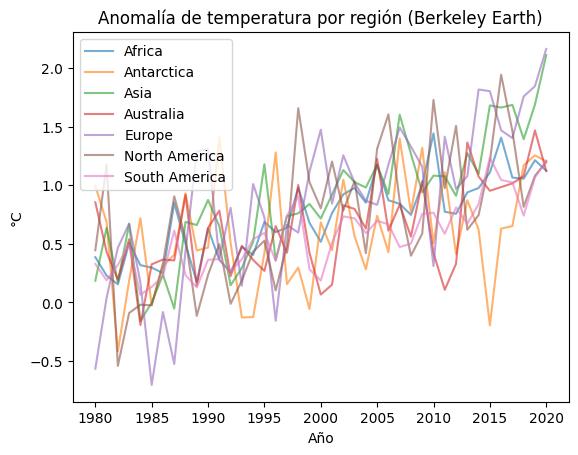

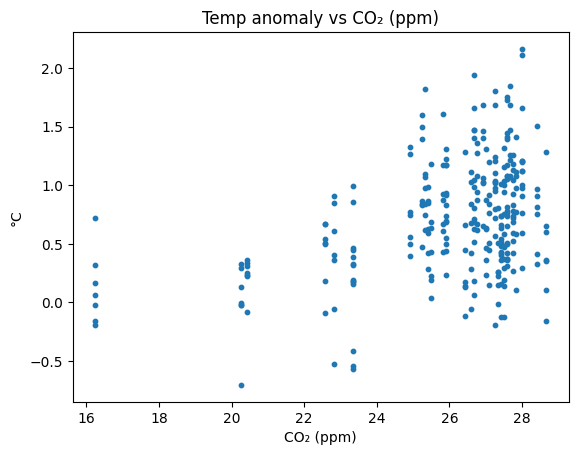

In [11]:

plt.figure();
for r, sub in panel.groupby('region'):
    plt.plot(sub['year'], sub['temp_anomaly_c'], label=r, alpha=0.6)
plt.legend(); plt.title("Anomalía de temperatura por región (Berkeley Earth)"); plt.xlabel("Año"); plt.ylabel("°C"); plt.show()

plt.figure(); plt.scatter(panel['co2_ppm'], panel['temp_anomaly_c'], s=10);
plt.title("Temp anomaly vs CO₂ (ppm)"); plt.xlabel("CO₂ (ppm)"); plt.ylabel("°C"); plt.show()

if 'aod' in panel.columns:
    plt.figure(); plt.scatter(panel['aod'], panel['temp_anomaly_c'], s=10);
    plt.title("Temp anomaly vs AOD (GISS)"); plt.xlabel("AOD"); plt.ylabel("°C"); plt.show()


## 4) Preparación

In [12]:

target='temp_anomaly_c'
X = panel.drop(columns=[target]).copy()
y = panel[target].copy()

cat_features = ['region']
num_features = [c for c in X.columns if c not in cat_features]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
])
# Split temporal: train ≤ 2016, test 2017–2024
train_mask = X['year']<=2016
X_train, X_test, y_train, y_test = X[train_mask], X[~train_mask], y[train_mask], y[~train_mask]
X_train.shape, X_test.shape


((259, 4), (28, 4))

## 5) Modelado y validación temporal

In [13]:

tscv = TimeSeriesSplit(n_splits=5)
models = {
    "Ridge": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=400, min_samples_split=4, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

for name, model in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', model)])
    scores = cross_val_score(pipe, X_train, y_train, cv=tscv, scoring='r2', n_jobs=-1)
    print(f"{name} | R2 CV mean: {scores.mean():.3f} +/- {scores.std():.3f}")


Ridge | R2 CV mean: 0.263 +/- 0.284
RandomForest | R2 CV mean: 0.211 +/- 0.304
GradientBoosting | R2 CV mean: 0.206 +/- 0.342


### 5.1 Entrenamiento final y evaluación en test

Ridge {'RMSE': np.float64(0.33), 'MAE': 0.239, 'R2': 0.194}


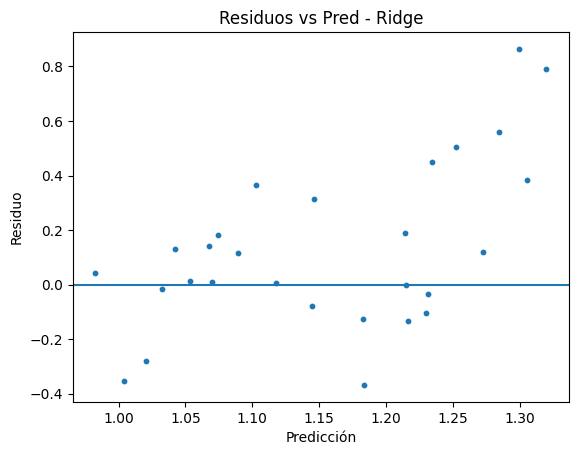

RandomForest {'RMSE': np.float64(0.305), 'MAE': 0.249, 'R2': 0.314}


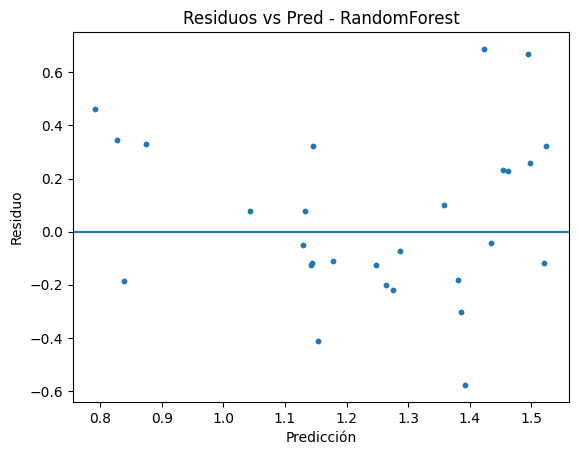

GradientBoosting {'RMSE': np.float64(0.38), 'MAE': 0.294, 'R2': -0.069}


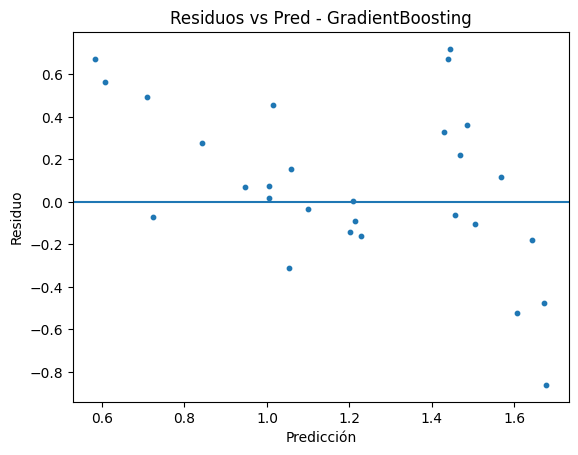

In [15]:

# --- Paso 5.1 robusto: evalúa RMSE aunque tu sklearn no soporte 'squared' ---
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def _rmse(y_true, y_pred):
    try:
        # sklearn ≥ 0.22
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # sklearn más antiguo: calculamos RMSE a mano
        return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_eval(model, name):
    pipe = Pipeline([('prep', preprocess), ('model', model)]).fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = _rmse(y_test, pred)
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)
    print(name, {"RMSE": round(rmse,3), "MAE": round(mae,3), "R2": round(r2,3)})

    # Residuos
    plt.figure()
    plt.scatter(pred, y_test.values - pred, s=10)
    plt.axhline(0)
    plt.title(f"Residuos vs Pred - {name}")
    plt.xlabel("Predicción")
    plt.ylabel("Residuo")
    plt.show()
    return pipe, pred

ridge_model, _ = fit_eval(models["Ridge"], "Ridge")
rf_model, _    = fit_eval(models["RandomForest"], "RandomForest")
gb_model, _    = fit_eval(models["GradientBoosting"], "GradientBoosting")

best_model = rf_model  # si querés, cambiá según la mejor métrica



## 6) Interpretabilidad (importancias y PDP)

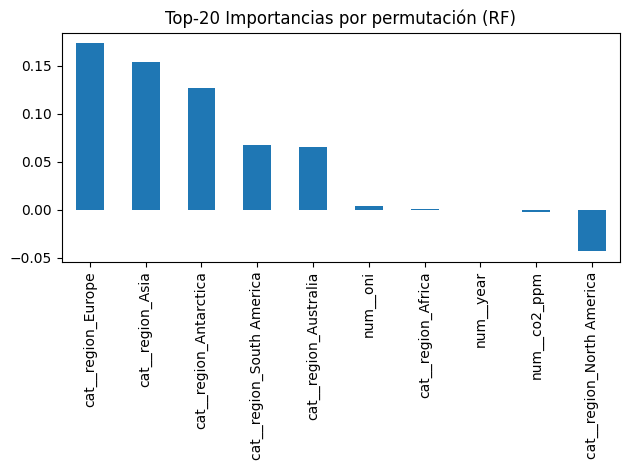

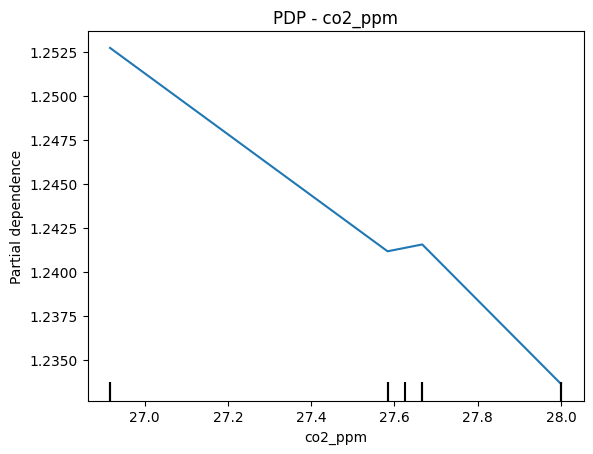

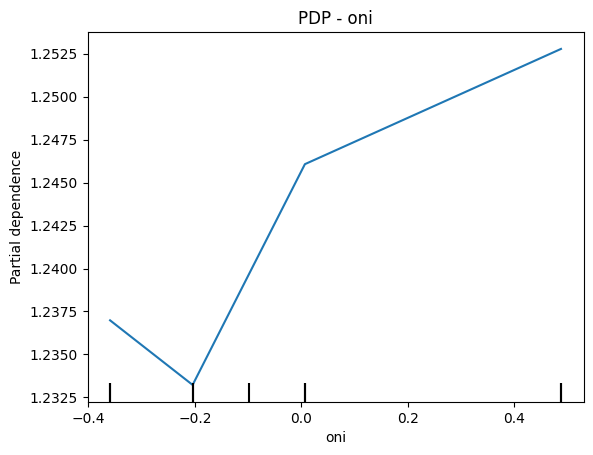

In [16]:

prep = rf_model.named_steps['prep']
clf  = rf_model.named_steps['model']
X_test_trans = prep.transform(X_test)

try:
    feature_names_trans = prep.get_feature_names_out()
except Exception:
    num_features = [c for c in X.columns if c not in ['region']]
    ohe = prep.named_transformers_['cat']
    names = list(num_features)
    if hasattr(ohe, 'get_feature_names_out'):
        names += list(ohe.get_feature_names_out(['region']))
    else:
        names += ['region_encoded']
    feature_names_trans = np.array(names)

result = permutation_importance(clf, X_test_trans, y_test, n_repeats=5, n_jobs=-1, random_state=RANDOM_STATE)
importances = pd.Series(result.importances_mean, index=feature_names_trans)
imp_top = importances.sort_values(ascending=False).head(20)

plt.figure(); imp_top.plot(kind='bar'); plt.title("Top-20 Importancias por permutación (RF)"); plt.tight_layout(); plt.show()

orig_cols = X_test.columns.tolist()
for f in ['co2_ppm','oni'] + (['aod'] if 'aod' in X_test.columns else []):
    if f in orig_cols:
        idx = orig_cols.index(f)
        try:
            PartialDependenceDisplay.from_estimator(rf_model, X_test, [idx])
            plt.title(f'PDP - {f}'); plt.show()
        except Exception as e:
            print("PDP falló en", f, "->", e)


## 7) Escenarios 2025–2035 (basados en tendencias reales)

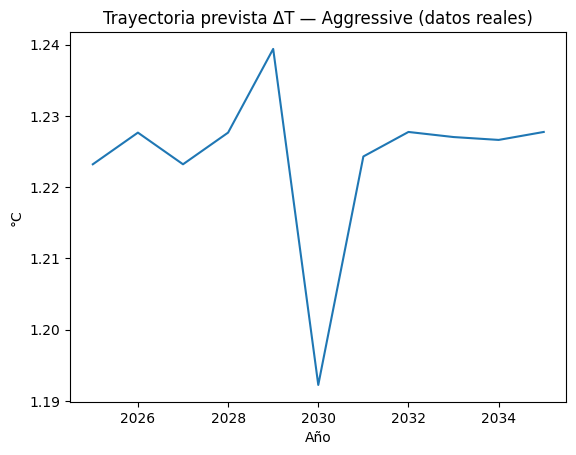

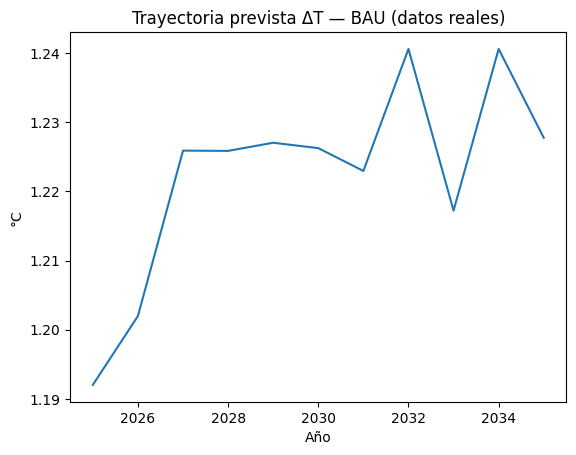

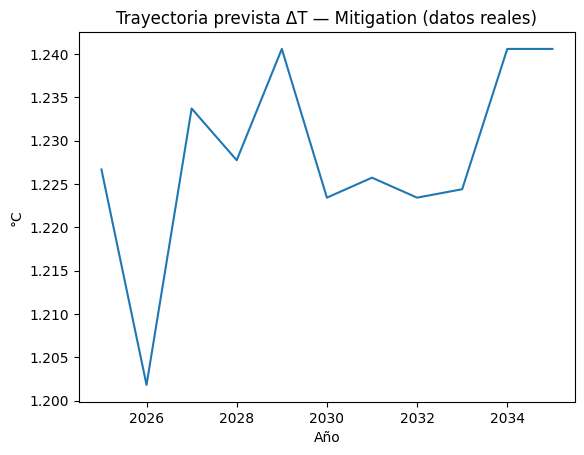

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Tendencia de CO2 (2010–2024) y escenarios
last = co2_y[co2_y['year'] >= 2010].dropna()
coef = np.polyfit(last['year'].astype(float), last['co2_ppm'].astype(float), 1)
co2_slope = float(coef[0])

def make_scenarios(start_year=2025, end_year=2035, slope=co2_slope):
    years = np.arange(start_year, end_year + 1)
    last_val = float(co2_y.loc[co2_y['year'] == co2_y['year'].max(), 'co2_ppm'].values[0])
    scens = {"BAU": slope, "Mitigation": slope * 0.6, "Aggressive": slope * 0.25}
    outs = []
    for name, m in scens.items():
        vals = last_val + m * np.arange(1, len(years) + 1)
        outs.append(pd.DataFrame({"scenario": name, "year": years, "co2_ppm": vals}))
    return pd.concat(outs, ignore_index=True)

co2_future = make_scenarios()

# 2) Fuente ONI para muestreo (mensual o anual, lo que exista)
if 'oni' in globals() and isinstance(oni, pd.DataFrame) and 'oni' in oni.columns:
    oni_hist = oni['oni'].dropna().values
elif 'oni_y' in globals() and isinstance(oni_y, pd.DataFrame) and 'oni' in oni_y.columns:
    oni_hist = oni_y['oni'].dropna().values
else:
    oni_hist = np.array([0.0])  # fallback neutro si no hay ONI

rng = np.random.default_rng(7)
def sample_oni(n):
    return rng.choice(oni_hist, size=n, replace=True) if len(oni_hist) > 1 else np.zeros(n)

# 3) Construir futuro con las MISMAS columnas que usó el modelo
training_features = X.columns.tolist()        # columnas con las que se entrenó
need_aod = 'aod' in training_features

rows = []
regions = sorted(panel['region'].unique())
for _, row in co2_future.iterrows():
    y = int(row['year'])
    co2v = float(row['co2_ppm'])
    oni_v = float(sample_oni(1)[0])
    for r in regions:
        item = {'scenario': row['scenario'], 'year': y, 'region': r, 'co2_ppm': co2v, 'oni': oni_v}
        if need_aod:
            # último AOD disponible o valor neutral si no existe
            if 'aod_y' in globals() and aod_y is not None and 'aod' in aod_y.columns:
                aod_last = float(aod_y[aod_y['year'] == aod_y['year'].max()]['aod'].values[0])
            else:
                aod_last = 0.02
            item['aod'] = aod_last
        rows.append(item)

future_df = pd.DataFrame(rows)

# Solo las features de entrenamiento (evita KeyError por columnas faltantes)
future_X = future_df[training_features]
future_df['pred_temp_anomaly_c'] = best_model.predict(future_X)

# Trayectoria promedio por escenario
g = future_df.groupby(['scenario', 'year'])['pred_temp_anomaly_c'].mean().reset_index()
for scn in g['scenario'].unique():
    sub = g[g['scenario'] == scn]
    plt.figure()
    plt.plot(sub['year'], sub['pred_temp_anomaly_c'])
    plt.title(f"Trayectoria prevista ΔT — {scn} (datos reales)")
    plt.xlabel("Año"); plt.ylabel("°C")
    plt.show()



## 8) Exportación e inferencia

In [19]:

MODEL_PATH = "modelo_clima_real_rf.joblib"
joblib.dump(best_model, MODEL_PATH)
print("Modelo guardado en:", MODEL_PATH)

def predecir_temp_anom(df_nuevo, model_path=MODEL_PATH):
    model = joblib.load(model_path)
    return model.predict(df_nuevo)

# Ejemplo rápido: usar la última fila del panel
ejemplo = panel.tail(1).drop(columns=['temp_anomaly_c'])
float(predecir_temp_anom(ejemplo)[0])


Modelo guardado en: modelo_clima_real_rf.joblib


0.8738066588504073

## 9) Notas de gobernanza y límites


- Este proyecto usa **datos reales** y repositorios oficiales (NOAA, Berkeley Earth, NASA GISS).  
- Aun así, **no** es una proyección científica formal: para *policy* real, integrar más forzantes (p. ej., aerosoles mejor caracterizados, TSI, AMO/NAO) y validar contra **GISTEMP/HadCRUT/ERA5** directamente.  
- Mantener registro de versiones de datos (fechas de descarga) y del modelo.
